# First rough model on the time data

I'm going to train ridge regression (a regularized linear model) to estimate log(time_narrated) from the text of passages.

To avoid just predicting authorial style, I'll set up crossvalidation so that passages from the same book are always grouped together. I'll also hold out passages from 18 books as a validation set, so we don't overfit through model design.

In [1]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
%matplotlib inline

### read in the data, separate validation set

In [18]:
data = pd.read_csv('2018segleveldata.csv')
print('Shape: ', data.shape)
print('Cols: ', list(data.columns))
print('Unique titles: ', len(set(data.title)))

Shape:  (1765, 9)
Cols:  ['title', 'date', 'time', 'timez', 'hardz', 'hardraw', 'dialog', 'col', 'text']
Unique titles:  108


In [19]:
unique_titles = list(set(data.title))

validation_titles = random.sample(unique_titles, 18)
validationset = data[data['title'].isin(validation_titles)]
data2model = data[~data['title'].isin(validation_titles)]
print('Validation set:', validationset.shape)
print('Data to model:', data2model.shape)

unique_titles = list(set(unique_titles) - set(validation_titles))
print('Remaining titles: ', len(unique_titles))

Validation set: (279, 9)
Data to model: (1486, 9)
Remaining titles:  90


We have removed 18 titles, and have 90 titles (1486 distinct 250-word segments) left to model. Write those titles to disk so that we can set aside the same validation set in the future, and while you're at it write out the data to model.

In [68]:
with open('validation_titles.txt', mode = 'w', encoding = 'utf-8') as f:
    for title in validation_titles:
        f.write(title + '\n')

data2model.to_csv('data2model.csv')

### create a matrix of word counts

We start with a naive approach that just uses the *n* most common words.

Scikit-learn has a CountVectorizer that makes this easy, but it has a few weaknesses. Punctuation would probably be useful, but this vectorizer nixes punctuation. We could fix that later if desired.

Also, because we're going to want to run grid search on the *n*, we need these words to be sorted by frequency, which isn't the default behavior. So, vectorize twice.

**First, to get a feature list, and sort it.**

In [21]:
vectorizer = CountVectorizer(max_features = 8000)
X = vectorizer.fit_transform(data2model.text)
features = vectorizer.get_feature_names()
count_array = X.toarray()
featurefreq = np.sum(count_array, axis = 0)
featuretuples = list(zip(featurefreq, features))
featuretuples.sort(reverse = True)
topfeatures = [x[1] for x in featuretuples[0: 8000]]
print(topfeatures[0:20])

['the', 'and', 'of', 'to', 'in', 'was', 'he', 'that', 'his', 'it', 'her', 'had', 'with', 'you', 'as', 'for', 'she', 'my', 'on', 'not']


**Second, to create the data with that sorted ordering.**

In [22]:
vectorizer = CountVectorizer(vocabulary = topfeatures)
X = vectorizer.fit_transform(data2model.text)
count_array = X.toarray()
df = pd.DataFrame(count_array, columns = topfeatures, index = data2model.title)
print(df.shape)
df.head()

(1486, 8000)


,the,and,of,to,in,was,he,that,his,it,...,acquiesced,acknowledgment,aching,achieving,ache,ab,_x_,99,97,77
title,,,,,,,,,,,,,,,,,,,,,
Boston Common,16,7,12,9,9,3,2,0,2,1,...,0,0,0,0,0,0,0,0,0,0
Boston Common,13,11,6,8,8,2,4,3,13,1,...,0,0,0,0,0,0,0,0,0,0
Boston Common,15,12,6,8,4,4,2,2,3,0,...,0,0,0,0,0,0,0,0,0,0
Boston Common,6,10,3,8,7,0,0,3,0,3,...,0,0,0,0,0,0,0,0,0,0
Boston Common,8,11,8,10,4,6,3,7,4,2,...,0,0,0,0,0,0,0,0,0,0


### Now for the actual modeling.

The function **model_holding_out** trains a model using all the titles except those contained in the iterable **holdout**. It predicts log(time) for all the segments with titles in **holdout,** and returns both the predictions and the actual (human-estimated) log(time).

In [43]:
def model_holding_out(data, metadata, holdout, alpha, num_variables):
    ''' Trains a model holding out fold # fold_index.
    '''
    
    trainset = data.drop(holdout)
    trainset = trainset.iloc[ : , 0 : num_variables]
    
    testset = data.loc[holdout, : ]
    testset = testset.iloc[ : , 0: num_variables]
    
    trainY = metadata.time[~metadata['title'].isin(holdout)]
    testY = metadata.time[metadata['title'].isin(holdout)]
    
    model = Ridge(alpha = alpha)
    model.fit(trainset, trainY)
    
    predictions = model.predict(testset)
    
    return predictions, testY

Now, using that function, we can build a grid search across possible values of the regularization constant and *n* most common words.

I do this using leave-one-out crossvalidation (leaving out one *title* at a time). That should be okay because I don't believe we ever repeat authors in this dataset. But in earlier experiments I got *much* -- almost order of magnitude -- lower accuracy using tenfold crossvalidation (creating ten groups of nine titles each). I'm not accustomed to seeing such a big difference between validation methods, and the cause is worth glancing at skeptically if we pursue this further. Is leave-one-out maybe too optimistic?

Also note that I'm not scaling/standardizing the features here, although I normally do that before training a regularized model. In earlier experiments the scaling didn't seem to help and actually hurt, but again, I want to understand why that would be.

In [69]:
def grid_test_leaveone(data, metadata):
    grid = []
    alpharange = [.000001, .001, .1, 1, 10, 100, 1000, 10000]
    varrange = [8000, 6000, 3000, 2000, 1000, 500, 250, 100]
    unique_titles = list(set(metadata.title))
    
    for alpha in alpharange:
        row = []
        for numvar in varrange:
            y = []
            yhat = []
            for t in unique_titles:
                holdout = [t]
                predictions, actual = model_holding_out(data, metadata, holdout, alpha, numvar)
                y.extend(actual)
                yhat.extend(predictions)
            r, p = pearsonr(y, yhat)
            print(alpha, numvar, r, p)
            row.append(r)
        grid.append(row)
    
    griddf = pd.DataFrame(grid, columns = varrange, index = alpharange)
    
    return griddf

### First modeling attempt, naive feature selection

Here's what the grid search looks like. Vertical axis is regularization constant, horizontal is number of features.

I am measuring success just as the Pearson correlation of predicted y values and actual y values, which seems kinda sorta analogous to mean squared error. David probably knows a better metric.

1e-06 8000 0.54439104883 2.05539089961e-115
1e-06 6000 0.534225158237 2.01382216051e-110
1e-06 3000 0.480133480294 1.54463032285e-86
1e-06 2000 0.396485171708 4.0158833437e-57
1e-06 1000 0.369591419397 2.61066729744e-49
1e-06 500 0.518870219827 3.36680359934e-103
1e-06 250 0.524042328825 1.36619363925e-105
1e-06 100 0.506597788687 1.09614952022e-97
0.001 8000 0.5443943254 2.04766080431e-115
0.001 6000 0.53422916249 2.00488084394e-110
0.001 3000 0.480144665682 1.52867870516e-86
0.001 2000 0.396519769887 3.91970078333e-57
0.001 1000 0.369679939075 2.4673087043e-49
0.001 500 0.518872850596 3.3574667793e-103
0.001 250 0.524042820662 1.36547216191e-105
0.001 100 0.506597858354 1.09607214148e-97
0.1 8000 0.544717497163 1.41178281377e-115
0.1 6000 0.534623666047 1.29289764338e-110
0.1 3000 0.481241969417 5.51095189705e-87
0.1 2000 0.399856829983 3.73148394224e-58
0.1 1000 0.377504466825 1.56168749295e-51
0.1 500 0.519132704884 2.55170847745e-103
0.1 250 0.524091520384 1.29588327089e-105
0.1 1

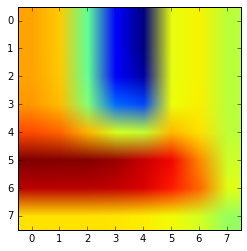

In [70]:
griddf = grid_test_leaveone(df, data2model)
plt.imshow(griddf)
plt.show()

In [71]:
colidx = griddf.max(axis = 0).idxmax()
rowidx = griddf.max(axis = 1).idxmax()
print('alpha = ', rowidx, 'numvar = ', colidx)
griddf.loc[rowidx, colidx]

alpha =  100.0 numvar =  8000


0.60692752434761754

That's not bad, although it hints that we could get even better accuracy with more features!

Let's look at a scatterplot of predicted log(time) versus actual.

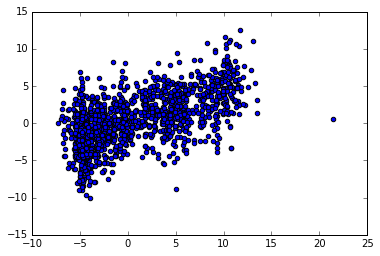

In [79]:
y = []
yhat = []
for t in unique_titles:
    predictions, actual = model_holding_out(df, data2model, [t], 100, 8000)
    y.extend(actual)
    yhat.extend(predictions)
plt.scatter(y, yhat)
plt.show()

#### Grouping results by volume.

How much better can we do if we aggregate / average all the predictions for volume segments?

In [80]:
results = pd.DataFrame({'title': data2model.title, 'actual': y, 'predicted': yhat})
grouped = results.groupby('title')
volavg = grouped.aggregate(np.mean)
volavg.head()

,actual,predicted
title,,
A Portrait of the Artist as a Young Man,0.073734,0.790168
A SICILIAN ROMANCE. BY THE AUTHORESS OF THE CASTLES OF ATHLIN AND DUNBAYNE. IN TWO VOLUMES.,-1.978903,-1.888601
A family history,3.745715,3.082421
A spy in the house of love,-0.754744,0.892429
A woman named Drown,-1.638981,-1.697709


(0.74676689805091756, 2.9158827272944856e-17)


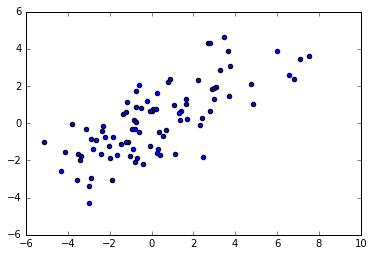

In [81]:
print(pearsonr(volavg.actual, volavg.predicted))
plt.scatter(volavg.actual, volavg.predicted)
plt.show()

*r* around 0.75 makes me pretty happy.

### Can we do better with intelligent feature selection?

There are certain features that I expect to matter a lot where time is concerned. Can we do better by enriching our feature sets with them?

In [73]:
timewords = ['hour', 'hours', 'minute', 'minutes', 'second', 'seconds', 
             'day', 'days', 'week', 'weeks', 'year', 'years', 'time', 'times',
            'heartbeat', 'instant', 'moment', 'breath', 'month', 'months',
            'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday',
            'sunday', 'morning', 'afternoon', 'evening', 'night', 'nights',
            'january', 'february', 'march', 'april', 'may', 'june', 'july',
            'august', 'september', 'october', 'november', 'december']
concretewords = ['red', 'yellow', 'blue', 'black', 'white', 'green', 'brown',
                 'face', 'hair', 'eyes', 'eye', 'arm', 'hands', 'hand', 'leg', 'legs',
                 'feet', 'foot', 'head', 'lips', 'ear', 'ears', 'nose']
dialoguewords = ['says', 'said', 'cried', 'exclaimed', 'replied', 'answered', 'asked',
                'muttered', 'giggled', 'laughed', 'smiled']
perceptionwords = ['see', 'saw', 'listened', 'listen', 'heard', 'hear', 'smelled', 
                   'smell', 'scent', 'odour', 'odor', 'taste']
specialwords = timewords + concretewords + dialoguewords + perceptionwords
print(len(specialwords))

90


In [74]:
vocabulary = specialwords + [x for x in topfeatures if x not in specialwords]
print(len(vocabulary))

8003


In [75]:
vectorizer = CountVectorizer(vocabulary = vocabulary)
X = vectorizer.fit_transform(data2model.text)
count_array = X.toarray()
newdf = pd.DataFrame(count_array, columns = vocabulary, index = data2model.title)
print(newdf.shape)
newdf.head()

(1486, 8003)


,hour,hours,minute,minutes,second,seconds,day,days,week,weeks,...,acquiesced,acknowledgment,aching,achieving,ache,ab,_x_,99,97,77
title,,,,,,,,,,,,,,,,,,,,,
Boston Common,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Boston Common,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Boston Common,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Boston Common,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Boston Common,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
griddf = grid_test_leaveone(newdf, data2model)


1e-06 8000 0.544310305605 2.25535114339e-115
1e-06 6000 0.534483709865 1.5107218029e-110
1e-06 3000 0.48007187386 1.63550702561e-86
1e-06 2000 0.383250699287 3.46802621397e-53
1e-06 1000 0.391671800441 1.1384485484e-55
1e-06 500 0.495962814237 4.34785172433e-93
1e-06 250 0.548205117596 2.48728347085e-117
1e-06 100 0.548988499959 9.97429834145e-118
0.001 8000 0.544313590755 2.24684916558e-115
0.001 6000 0.534487695918 1.50403887134e-110
0.001 3000 0.480082838923 1.61895129066e-86
0.001 2000 0.383288796332 3.3807158216e-53
0.001 1000 0.391732466747 1.09183212443e-55
0.001 500 0.495974550414 4.29822559689e-93
0.001 250 0.548213832497 2.46216019574e-117
0.001 100 0.548999177153 9.85068132462e-118
0.1 8000 0.544636853713 1.54910987491e-115
0.1 6000 0.53488046656 9.71420598251e-111
0.1 3000 0.481158192642 5.95816433137e-87
0.1 2000 0.386964038328 2.84308888978e-54
0.1 1000 0.397093453031 2.62119411961e-57
0.1 500 0.497043628375 1.50775118758e-93
0.1 250 0.548996916919 9.87672145361e-118
0.1 

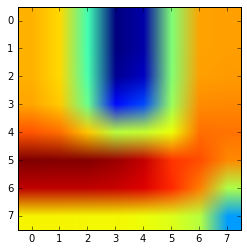

In [77]:
plt.imshow(griddf)
plt.show()

In [78]:
colidx = griddf.max(axis = 0).idxmax()
rowidx = griddf.max(axis = 1).idxmax()
print('alpha = ', rowidx, 'numvar = ', colidx)
griddf.loc[rowidx, colidx]

alpha =  100.0 numvar =  8000


0.60689036352011749

Basically, human feature selection does improve performance at low variable-counts. But it doesn't beat high variable-counts. Automated feature selection might still be worth a try.

### Let's try scaling features.

In [87]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns = topfeatures, index = data2model.title)
print(scaled_df.shape)

(1486, 8000)


In [91]:
# Creating a new function because the scaled data profits from higher alpha.

def grid_test_forscaled(data, metadata):
    grid = []
    alpharange = [100, 1000, 10000, 100000, 1000000]
    varrange = [8000, 6000, 3000, 2000, 1000, 500]
    unique_titles = list(set(metadata.title))
    
    for alpha in alpharange:
        row = []
        for numvar in varrange:
            y = []
            yhat = []
            for t in unique_titles:
                holdout = [t]
                predictions, actual = model_holding_out(data, metadata, holdout, alpha, numvar)
                y.extend(actual)
                yhat.extend(predictions)
            r, p = pearsonr(y, yhat)
            print(alpha, numvar, r, p)
            row.append(r)
        grid.append(row)
    
    griddf = pd.DataFrame(grid, columns = varrange, index = alpharange)
    
    return griddf

In [ ]:
griddf = grid_test_forscaled(scaled_df, data2model)

100 8000 0.588936291599 1.93697204492e-139
100 6000 0.569511679938 1.64693609148e-128
100 3000 0.513038272325 1.49618518979e-100
100 2000 0.450609393914 3.33843144517e-75
100